n = 10
Accuracy: 33.01%
Recall: 30.20%
Precision: 30.86%
F1 Score: 30.19%
Confusion Matrix:
 [[48 22  9 21]
 [26  9  7 19]
 [18 11 13 14]
 [33 14 11 31]]
--------------------------------------------------
n = 20
Accuracy: 32.35%
Recall: 29.42%
Precision: 29.24%
F1 Score: 29.16%
Confusion Matrix:
 [[42 16 14 28]
 [18 11 10 22]
 [21 15  9 11]
 [32  9 11 37]]
--------------------------------------------------
n = 30
Accuracy: 31.37%
Recall: 28.77%
Precision: 29.21%
F1 Score: 28.71%
Confusion Matrix:
 [[41 17 17 25]
 [25 11  5 20]
 [23 11 10 12]
 [34 13  8 34]]
--------------------------------------------------
n = 40
Accuracy: 31.37%
Recall: 28.35%
Precision: 28.05%
F1 Score: 28.01%
Confusion Matrix:
 [[41 13 14 32]
 [24  9 10 18]
 [20 14  9 13]
 [28 14 10 37]]
--------------------------------------------------
n = 50
Accuracy: 30.39%
Recall: 28.20%
Precision: 28.60%
F1 Score: 28.19%
Confusion Matrix:
 [[40 18 15 27]
 [25  9  7 20]
 [18 12 13 13]
 [38 10 10 31]]
--------------------------

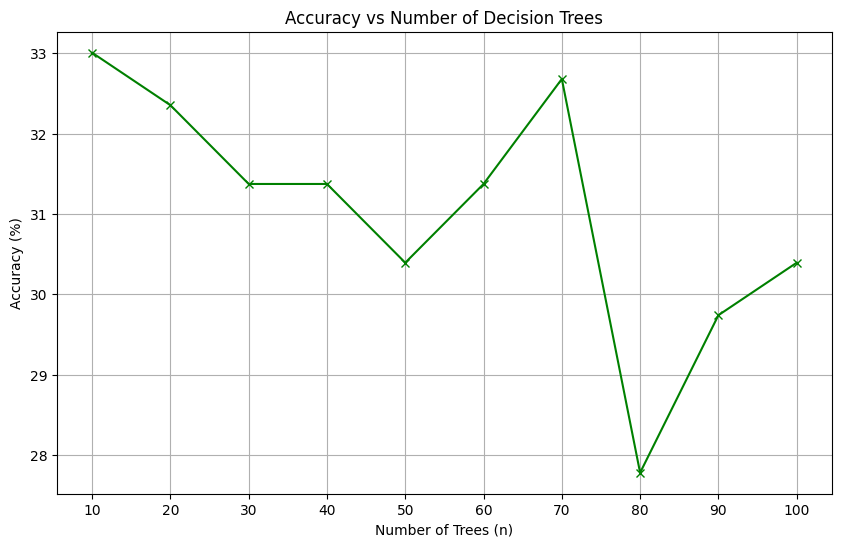

Best Number of Decision Trees: 10
Accuracy: 29.739%
Macro Precision: 26.959%
Micro Precision: 29.739%
Macro Recall: 27.012%
Micro Recall: 29.739%
F1 Score (Macro): 26.828%
F1 Score (Micro): 29.739%


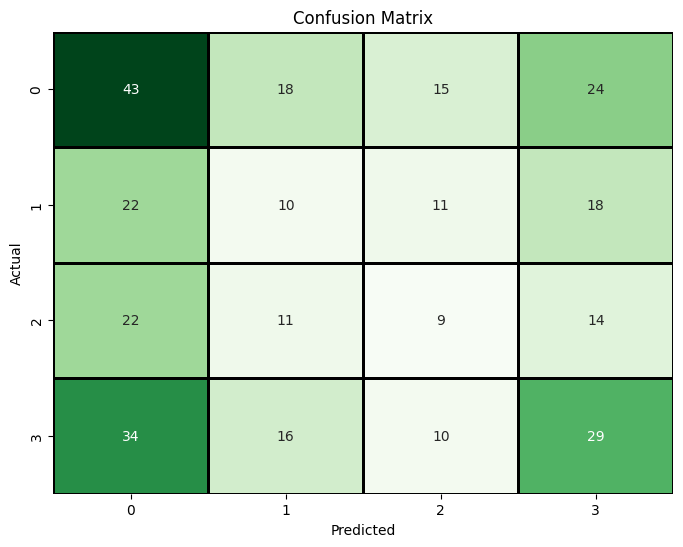

In [26]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_data = pd.read_csv("Customer_train.csv")
test_data = pd.read_csv("Customer_test.csv")

# Data preprocessing: Removing NaN entries, encoding categorical features, and normalizing numerical data
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Defining features and target variable
features = train_data.drop(columns=["ID", "Segmentation"])
target = train_data["Segmentation"]

features_test = test_data.drop(columns=["ID"])  # Test set lacks 'Segmentation'

# Encoding categorical features
label_encoders = {}
cat_columns = features.select_dtypes(include=["object"]).columns

for column in cat_columns:
    encoder = LabelEncoder()
    features[column] = encoder.fit_transform(features[column])
    if column in test_data.columns:
        features_test[column] = encoder.transform(features_test[column])
    label_encoders[column] = encoder

# Normalizing numerical features
scaler = StandardScaler()
num_columns = features.select_dtypes(include=["int64", "float64"]).columns
features[num_columns] = scaler.fit_transform(features[num_columns])
features_test[num_columns] = scaler.transform(features_test[num_columns])

# Splitting the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Custom implementation of Random Forest using decision trees
class CustomRandomForest():
    def __init__(self, n_estimators, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.models = []
    
    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
        
    def fit(self, X_train, y_train):
        for _ in range(self.n_estimators):
            X_bootstrap, y_bootstrap = self.bootstrap_sample(X_train, y_train)
            tree = DecisionTreeClassifier(
                criterion="entropy",
                splitter="best",
                max_features="sqrt",
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=42
            )
            tree.fit(X_bootstrap, y_bootstrap)
            self.models.append(tree)
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        final_predictions = []
        for i in range(predictions.shape[1]):
            unique, counts = np.unique(predictions[:, i], return_counts=True)
            most_common_index = np.argmax(counts)
            final_predictions.append(unique[most_common_index])
        return final_predictions

# Testing various numbers of trees
tree_counts = np.arange(10, 101, 10)
accuracies = []

for n in tree_counts:
    rf_model = CustomRandomForest(n_estimators=n)
    rf_model.fit(X_train.values, y_train.values)
    predictions = rf_model.predict(X_val.values)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, predictions)
    accuracies.append(accuracy)
    
    # Display performance metrics
    print(f"n = {n}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Recall: {recall_score(y_val, predictions, average='macro') * 100:.2f}%")
    print(f"Precision: {precision_score(y_val, predictions, average='macro') * 100:.2f}%")
    print(f"F1 Score: {f1_score(y_val, predictions, average='macro') * 100:.2f}%")
    print(f"Confusion Matrix:\n {confusion_matrix(y_val, predictions)}")
    print("-" * 50)

# Plot accuracy against number of trees
plt.figure(figsize=(10, 6))
plt.plot(tree_counts, np.array(accuracies) * 100, marker='x', color='green')
plt.xlabel("Number of Trees (n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Number of Decision Trees")
plt.xticks(tree_counts)
plt.grid()
plt.show()

# Determine the optimal number of trees
optimal_n = tree_counts[np.argmax(accuracies)]
print(f"Best Number of Decision Trees: {optimal_n}")

# Train the model with the best number of trees
best_rf_model = CustomRandomForest(n_estimators=optimal_n)
best_rf_model.fit(X_train.values, y_train.values)
final_predictions = best_rf_model.predict(X_val.values)

# Metrics for the best model in percentage with 3 decimal places
best_accuracy = accuracy_score(y_val, final_predictions)
best_precision_macro = precision_score(y_val, final_predictions, average="macro")
best_precision_micro = precision_score(y_val, final_predictions, average="micro")
best_recall_macro = recall_score(y_val, final_predictions, average="macro")
best_recall_micro = recall_score(y_val, final_predictions, average="micro")
best_f1_macro = f1_score(y_val, final_predictions, average="macro")
best_f1_micro = f1_score(y_val, final_predictions, average="micro")

print(f"Accuracy: {best_accuracy * 100:.3f}%") 
print(f"Macro Precision: {best_precision_macro * 100:.3f}%")
print(f"Micro Precision: {best_precision_micro * 100:.3f}%")
print(f"Macro Recall: {best_recall_macro * 100:.3f}%")
print(f"Micro Recall: {best_recall_micro * 100:.3f}%")
print(f"F1 Score (Macro): {best_f1_macro * 100:.3f}%")
print(f"F1 Score (Micro): {best_f1_micro * 100:.3f}%")

# Predictions on the test dataset
test_predictions = best_rf_model.predict(features_test.values)

# Save predictions to a CSV file
with open('random.csv', 'w') as output_file:
    output_file.write("predicted\n")
    for prediction in test_predictions:
        output_file.write(f"{prediction}\n")

# Confusion Matrix for the validation set predictions
confusion_mat = confusion_matrix(y_val, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens", linewidths=1, linecolor="k", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
